# Embedding av vedtak
Vi skal embedde alle vedtakene i korpuset. Til dette trenger vi en embeddingsmodell (merk: dette er ikke det samme som en språkmodell *a la* GPT-4). Her skal vi bruke OpenAIs `text-embedding-3-large`. Dette er en multilingual modell som embedder dokumenter slik at de blir representert som en vektor i et 3072 dimensjonalt rom. Maks dokumentlengde er 8191 tokens.

## Antall tokens i dokumentene
Embeddingmodellene har en begrenset dokumentlengde. Modellen vi bruker her, `text-embedding-3-large`, tar maks 8191 tokens. I følge dokumentasjonen bruker den `cl100k_base`som tokenizer. Vi tokenserer derfor alle vedtakene og sjekker hvor mange tokens det lengste vedtaket har. 
 

In [74]:
import tiktoken

def num_tokens_from_string(string: str, encoding_name: str) -> int:
    """Returns the number of tokens in a text string."""
    encoding = tiktoken.get_encoding(encoding_name)
    num_tokens = len(encoding.encode(string))
    return num_tokens

In [75]:
import os

tokens_list = []
# Define the directory containing the files
directory = './transportklagenmnda_txt/'

# Process each file in the directory
for filename in os.listdir(directory):
    file_path = os.path.join(directory, filename)
    
    # Check if it is a file
    if os.path.isfile(file_path):
        try:
            # Open and process the file (example: reading content)
            with open(file_path, 'r') as file:
                content = file.read()
                # Example: print the first 100 characters of each file
                num_tokens = num_tokens_from_string(content, 'cl100k_base')
                tokens_list.append(num_tokens)
        except Exception as e:
            print(f"Error processing file {filename}: {e}")


In [76]:
max(tokens_list)

7654

Vi har at det lengste vedtaket er kortere enn maks lengde (8191). Vi kan derfor embedde alle vedtak som fulltekst -- dvs. vi trenger verken å trunkere eller dele vedtakene opp i «chunker».

## Oppretting av database og embedding av dokumenter.
For å lagre informasjon om embeddede dokumenter trenger vi en vektordatabase. Her bruker vi ChromaDB og lagrer informasjonen lokalt. Videre bruker vo ChromaDBs grensesnitt for å embedde vedtakene med `text-embedding-3-large`.

In [68]:
# Om dette skal gjøres flere ganger, pga. feilmeldinger eller lignende, må den gamle databasen slettes først.
# collection = client.delete_collection(name="openai_3_large")


In [70]:
import chromadb
import chromadb.utils.embedding_functions as embedding_functions
import json
import os

openai_api_key = os.getenv('OPENAI_API_KEY')


openai_ef = embedding_functions.OpenAIEmbeddingFunction(
                api_key = openai_api_key,
                model_name="text-embedding-3-large"
            )

client = chromadb.PersistentClient(path='./db')


collection = client.get_or_create_collection(name="openai_3_large", embedding_function=openai_ef)


In [ ]:
import json
import time

# Define the batch size
batch_size = 100  # You can adjust the batch size as needed

# Initialize lists to store batch data
ids = []
documents = []
metadatas = []

with open('vedtak.jsonl', 'r', encoding='utf-8') as jsonl_file:
    for line_number, line in enumerate(jsonl_file, start=1):
        json_obj = json.loads(line)
        
        # Extract fields
        doc_id = json_obj.get('id', '')
        nemnd = json_obj.get('nemnd', '')
        content = json_obj.get('content', '')
        
        # Skip entries with missing content or id
        if not doc_id or not content:
            print(f"Skipping entry with missing id or content: {json_obj}")
            continue
        
        # Append to batch lists
        ids.append(doc_id)
        documents.append(content)
        metadatas.append({'nemnd': nemnd})
        
        # When batch size is reached, add data to the collection and reset lists
        if len(ids) >= batch_size:
            collection.add(
                documents=documents,
                metadatas=metadatas,
                ids=ids
            )
            print(f"Added batch of {len(ids)} documents to collection.")
            
            # Clear the batch lists for the next batch
            ids = []
            documents = []
            metadatas = []
            
            # Pause for 5 seconds between batches
            time.sleep(10)
    
    # After processing all lines, check if there is any remaining data
    if ids:
        collection.add(
            documents=documents,
            metadatas=metadatas,
            ids=ids
        )
        print(f"Added final batch of {len(ids)} documents to collection.")

print("All data has been added to the collection.")


### Kvalitetssikring

Alle embeddingen ser ut til å ha gått bra. Vi sjekker først antall enheter i databsen.

In [67]:
collection.count()

13974

Dette tallet stemmer med antallet vedtak i korpuset.

Så sjekker vi antall dimensjoner i embeddingene.

In [85]:
# Henter inn ett dokument fra basen
sample_embedding = collection.peek(limit=1)  

# Henter inn embeddingene fra dokumentet
embedding_array = sample_embedding['embeddings']
dimensions = embedding_array.shape[1]
print(f"Embeddingene har {dimensions} dimensjoner.")


Embeddingene har 3072 dimensjoner.


## Visualisering

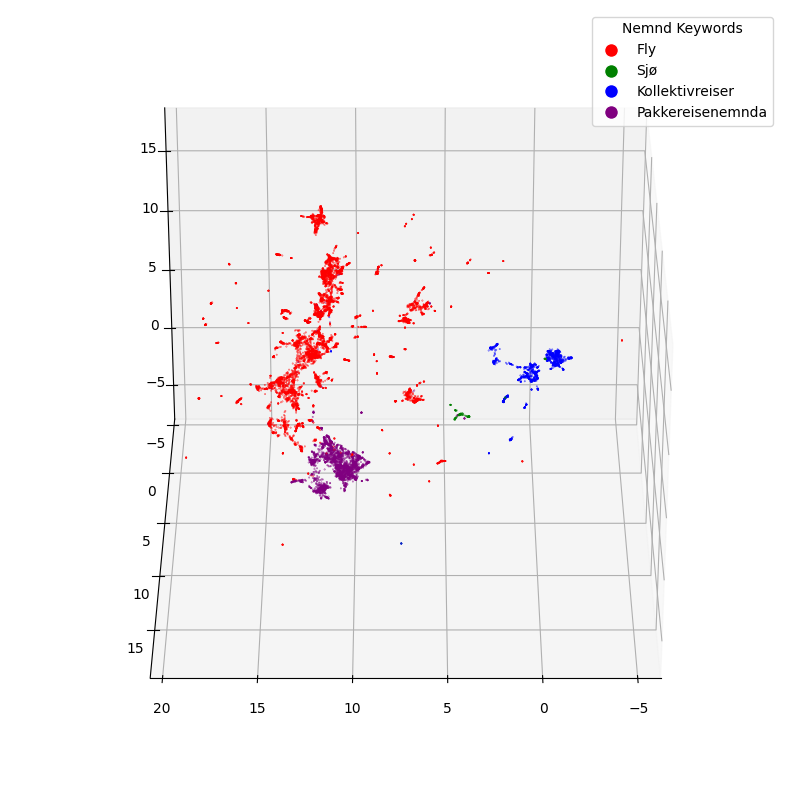

In [99]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
from umap.umap_ import UMAP




# Get the embeddings for the support documents from the collection
support_embeddings = collection.get(include=['embeddings'])['embeddings']

# Get the 'metadatas' for each point
metadata_list = collection.get(include=['metadatas'])['metadatas']

# Extract 'nemnd' values from the metadata list
nemnd_values = [meta['nemnd'] for meta in metadata_list]

# Define an integer mapping for each nemnd value
nemnd_keywords = ["Fly", "Sjø", "Kollektivreiser", "Pakkereisenemnda"]
int_map = {"Fly": 0, "Sjø": 1, "Kollektivreiser": 2, "Pakkereisenemnda": 3}
int_values = np.array([int_map[val] for val in nemnd_values])

# Define a custom colormap
colors = ["red", "green", "blue", "purple"]

# 1. Modify UMAP to project to 3D
mapper = UMAP(n_components=3).fit(support_embeddings)

# Extract the 3D coordinates
x = mapper.embedding_[:, 0]
y = mapper.embedding_[:, 1]
z = mapper.embedding_[:, 2]

# Define a custom colormap
colors = ["red", "green", "blue", "purple"]
custom_cmap = ListedColormap(colors)

# 2. Plot using matplotlib's 3D capabilities
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Rotate the view 30 degrees clockwise
elev = ax.elev  # Keep the current elevation angle
azim = ax.azim  # Get the current azimuthal angle
ax.view_init(elev=elev, azim=azim+150)  # Adjust the azimuthal angle by 30 degrees


# Scatter plot with custom colors and transparency
scatter = ax.scatter(x, y, z, c=int_values, cmap=custom_cmap, s=0.1, alpha=0.8)

# Create a legend for the custom colormap
handles = [plt.Line2D([0], [0], linestyle='', marker='o', color='w', markerfacecolor=col, markersize=10) for col in colors]
ax.legend(handles, nemnd_keywords, title="Nemnd Keywords")

plt.show()
